# Zarr ECCO ds - cleaned version

In [2]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [46]:
cluster.close()
client.close()

In [3]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.8c7eb4f85e834ce18bd9a897b06df9d0/status,


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [5]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [6]:
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
ds

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'k', 'left': 'k_l', 'outer': 'k_p1', 'right': 'k_u'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [8]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where 
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(ds['ADVx_' + suffix], 'X') +
                          grid.diff(ds['ADVy_' + suffix], 'Y', boundary='fill')).rename('conv_horiz_adv_flux_' + suffix)
    conv_horiz_diff_flux = -(grid.diff(ds['DFxE_' + suffix], 'X') +
                          grid.diff(ds['DFyE_' + suffix], 'Y', boundary='fill')).rename('conv_horiz_diff_flux_' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(ds['ADVr_' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(ds['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(ds['DFrI_' + suffix], 'Z', boundary='fill')).rename('conv_vert_diff_flux_' + suffix)
    
    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    #conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)
    #return xr.merge(all_fluxes + [conv_all_fluxes])
    return xr.merge(all_fluxes)

In [9]:
# sum of all converging adv/diff fluxes
budget_slt = tracer_flux_budget('SLT')
budget_slt

,Array,Chunk
Bytes,5.21 GiB,1.53 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 89, 90)"
Count,89 Graph Layers,6912 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.53 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 89, 90)"
Count,89 Graph Layers,6912 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
budget_th = tracer_flux_budget('TH')
budget_th

,Array,Chunk
Bytes,5.21 GiB,1.53 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 89, 90)"
Count,89 Graph Layers,6912 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.53 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 89, 90)"
Count,89 Graph Layers,6912 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**Theta Tendency Term**

In [11]:
#calculating total tendency term for heat
delta_theta = ds.THETA_snp.diff('time_snp')

#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
delta_theta

,Array,Chunk
Bytes,5.18 GiB,1.54 MiB
Shape,"(286, 50, 270, 360)","(1, 50, 90, 90)"
Count,34 Graph Layers,3432 Chunks
Type,float32,numpy.ndarray


In [12]:
theta_tend = (delta_theta / coords.dt[1:287])

**Salt Tendency Term**

In [13]:
#calculating total tendency term for salt
delta_salt = ds.SALT_snp.diff('time_snp')
#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
delta_salt

,Array,Chunk
Bytes,5.18 GiB,1.54 MiB
Shape,"(286, 50, 270, 360)","(1, 50, 90, 90)"
Count,34 Graph Layers,3432 Chunks
Type,float32,numpy.ndarray


In [14]:
salt_tend = (delta_salt / coords.dt[1:287])
#units: g/kg*s (psu/s)

In [15]:
volume = (coords.drF * coords.rA * coords.hFacC)
#day2seconds = (24*60*60)
totttend = theta_tend * volume
totstend = salt_tend * volume

In [16]:
#adding calculated total tendency
budget_th['total_tendency_TH_truth'] = totttend
budget_slt['total_tendency_SLT_truth'] = totstend

In [17]:
#rechunking
budget_th['total_tendency_TH_truth'] = budget_th.total_tendency_TH_truth.chunk({'time':1})
budget_slt['total_tendency_SLT_truth'] = budget_slt.total_tendency_SLT_truth.chunk({'time':1})

In [18]:
runit2mass = 1.035e3 #kg/m^3
salt_plume = ((ds.oceSPtnd * coords.rA)/runit2mass)#.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
salt_plume

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,65 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray


### Surface Fluxes

The surface fluxes are only active in the top model layer. We need to specify some constants to convert to the proper units and scale factors to convert to integral form. They also require some xarray special sauce to merge with the 3D variables.

In [19]:
# constants
heat_capacity_cp = 3.994e3 #J/kg˚C
runit2mass = 1.035e3 #kg/m3

# treat the shortwave flux separately from the rest of the surface flux

#surf flux
surf_flux_th = (ds.TFLUX - ds.oceQsw) * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass) #˚C m^3/s
_, surf_flux_th_aligned = xr.align(coords.hFacC, surf_flux_th.expand_dims('k'), join='outer')
surf_flux_th_aligned = surf_flux_th_aligned.fillna(0.)

#sw flux
surf_flux_th_sw = ds.oceQsw * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass) #˚C m^3/s

# salt
surf_flux_slt = ds.SFLUX * coords.rA * coords.hFacC.isel(k=0) / runit2mass
surf_flux_slt.coords['k'] = coords.k[0]
_, surf_flux_slt_aligned = xr.align(coords.hFacC, surf_flux_slt.expand_dims('k'), join='outer')
surf_flux_slt_aligned = surf_flux_slt_aligned.fillna(0.)
#units: (psu m^3)/s

In [20]:
budget_slt['salt_plume'] = salt_plume
budget_slt['surface_flux_SLT'] = surf_flux_slt_aligned

### Shortwave Flux

Special treatment is needed for the shortwave flux, which penetrates into the interior of the water column

In [21]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(k_l=slice(0, 18))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(coords.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [22]:
#convergence of swdown
sw = -grid.diff(swdown, 'Z', boundary='fill')
sw

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 270, 360, 50)","(1, 90, 90, 50)"
Count,138 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray


In [23]:
budget_th['surface_flux_conv_TH'] = surf_flux_th_aligned

budget_th['sw_flux_conv_TH'] = sw

In [24]:
budget_th = budget_th.chunk({'i': -1, 'j': -1, 'k': -1, 'time': 1})
budget_th

,Array,Chunk
Bytes,5.21 GiB,18.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 270, 360)"
Count,90 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,18.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 270, 360)"
Count,90 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [25]:
budget_slt = budget_slt.chunk({'i': -1, 'j': -1, 'k': -1, 'time': 1})
budget_slt

,Array,Chunk
Bytes,5.21 GiB,18.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 270, 360)"
Count,90 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,18.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 270, 360)"
Count,90 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## **Quick check**

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
mask = coords.hFacC[0]>0

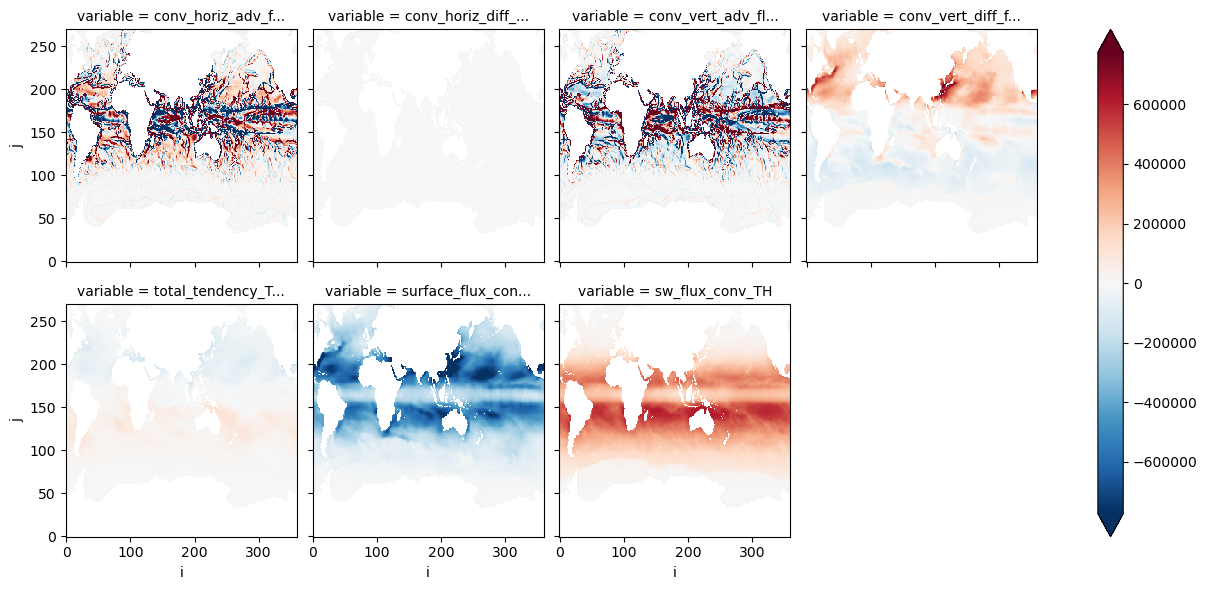

In [28]:
budget_th.where(mask).isel(time=10, k=0).to_array().plot(col='variable', col_wrap=4, 
                                                        robust=True);#, vmin=-4e5, vmax=4e4);

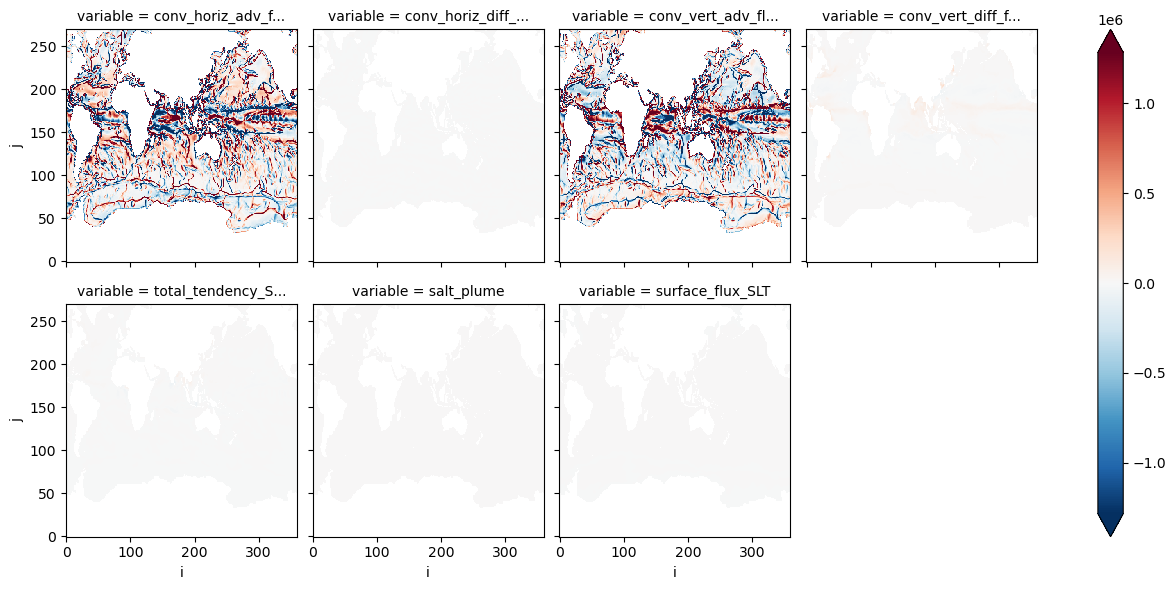

In [29]:
budget_slt.where(mask).isel(time=10, k=0).to_array().plot(col='variable', col_wrap=4, 
                                                        robust=True);#, vmin=-4e5, vmax=4e4);

### TEMP check

In [30]:
lhs = budget_th.total_tendency_TH_truth

In [31]:
#sum all terms except for tottend
rhs = budget_th.to_array().sum('variable') - budget_th.total_tendency_TH_truth

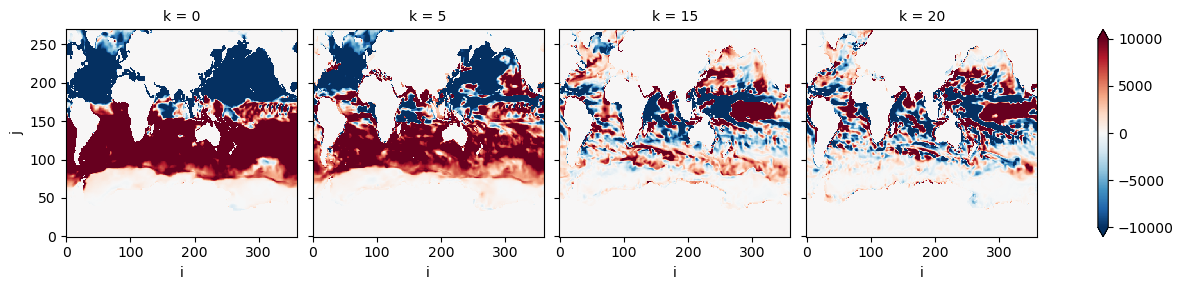

In [32]:
rhs.isel(time=10, k=[0, 5, 15, 20]).plot(col='k', vmin=-1e4, vmax=1e4, cmap='RdBu_r');

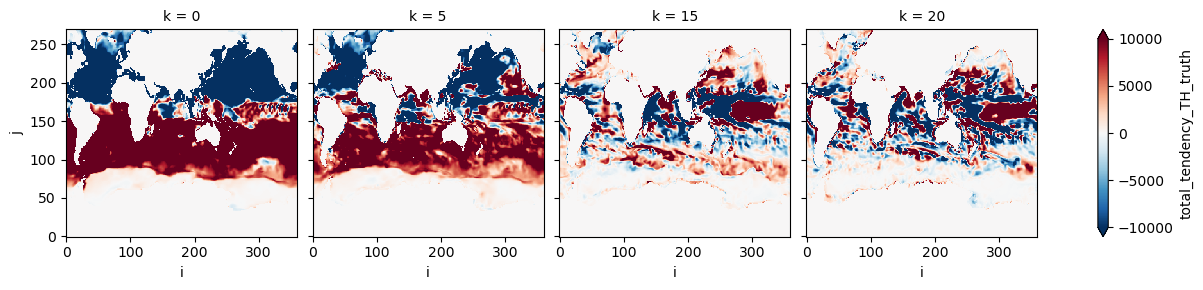

In [33]:
lhs.isel(time=10, k=[0, 5, 15, 20]).plot(col='k', vmin=-1e4, vmax=1e4, cmap='RdBu_r');

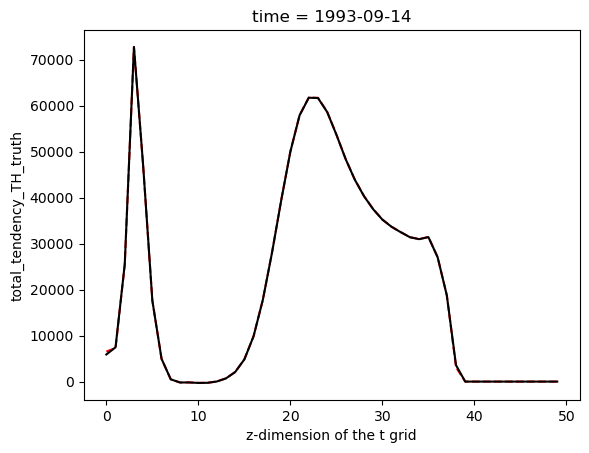

In [34]:
rhs.isel(j=170, i=356, time=20).plot(label='rhs', color='r', linestyle='dashed')
lhs.isel(j=170, i=356, time=20).plot(label='lsh', color='k')

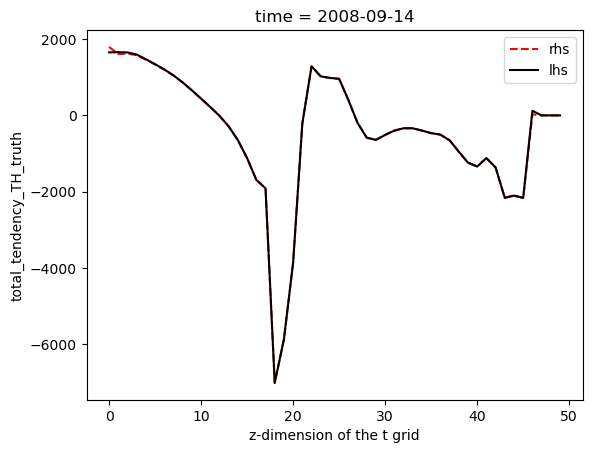

In [35]:
#rolling coords causes the slight discrepencies. 
#No diff if you roll at beginning when loading in ds, or when rolling as you plot this
rhs[200,:,100,356].plot(label='rhs', color='r', linestyle='--')
lhs[200,:,100,356].plot(label='lhs', color='k')
plt.legend();

### SALT check

In [36]:
lhs = budget_slt.total_tendency_SLT_truth

In [37]:
#sum all terms except for tottend
rhs = budget_slt.to_array().sum('variable') - budget_slt.total_tendency_SLT_truth

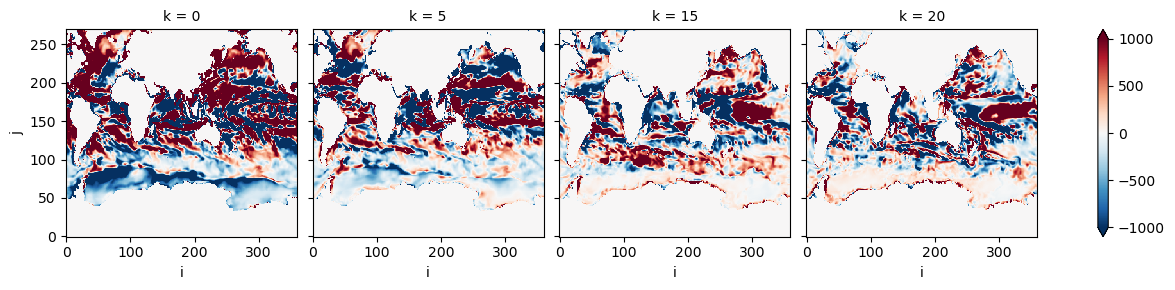

In [38]:
rhs.isel(time=10, k=[0, 5, 15, 20]).plot(col='k', vmin=-1e3, vmax=1e3, cmap='RdBu_r');

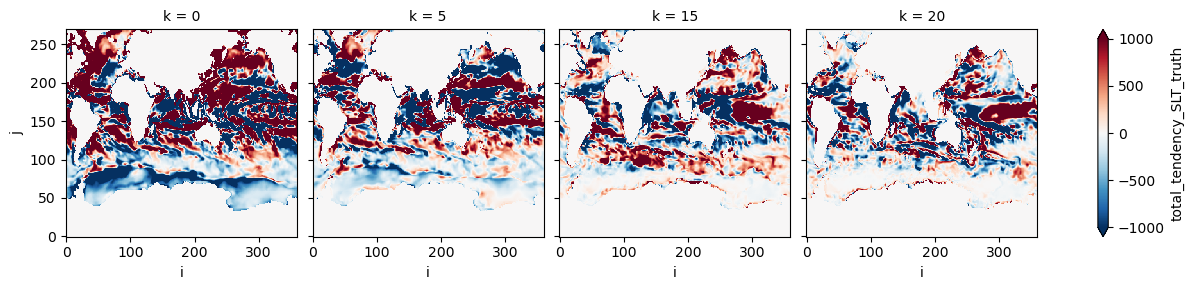

In [39]:
lhs.isel(time=10, k=[0, 5, 15, 20]).plot(col='k', vmin=-1e3, vmax=1e3, cmap='RdBu_r');

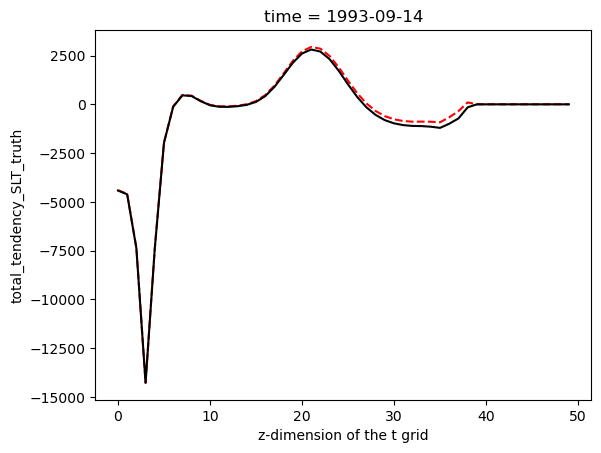

In [40]:
rhs.isel(j=170, i=356, time=20).plot(label='rhs', color='r', linestyle='dashed')
lhs.isel(j=170, i=356, time=20).plot(label='lsh', color='k')

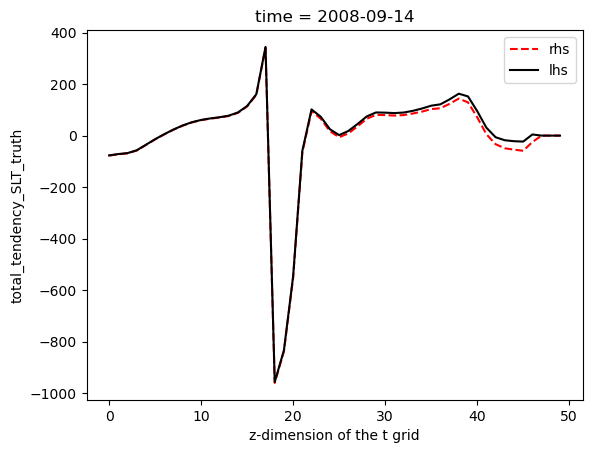

In [41]:
#salt plume is 0, makes no diff
rhs[200,:,100,356].plot(label='rhs', color='r', linestyle='--')
lhs[200,:,100,356].plot(label='lhs', color='k')
plt.legend();

## Saving Data

In [42]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [47]:
#saving heat budget ds
gcsmap_th = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/budget_th.zarr')
budget_th.to_zarr(gcsmap_th, mode='w')

In [48]:
#saving salt budget ds
gcsmap_slt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/budget_slt.zarr')
budget_slt.to_zarr(gcsmap_slt, mode='w')